# Task: Predicting Healthcare Expenditure

The goal of this task is to predict the healthcare expense based on the patient's data. The healthcare expense column is the total lifetime cost of healthcare to the patient (i.e. what the patient paid). Thus, it is a regression problem as the output is continuous. 

## Necessary imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import seaborn as sb
import matplotlib.pyplot as plt
import datetime
from datetime import date
from sklearn.decomposition import PCA

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 6.3 MB/s eta 0:00:00


## Data Preparation

#### All patients - Observations

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading observations dataset
observations_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/observations.csv') 

In [ ]:
preproc_obs_df = observations_df.drop(columns = ['UNITS', 'TYPE', 'CODE'])

In [ ]:
n = 5# set number of features (any number above 7 led to overfitting)
selected = preproc_obs_df['DESCRIPTION'].value_counts()[:n].index.tolist()
new_preproc_obs_df = preproc_obs_df[preproc_obs_df['DESCRIPTION'].isin(selected)]

In [ ]:
new_preproc_obs_df['VALUE'] = pd.to_numeric(new_preproc_obs_df.VALUE.astype(str).str.replace(',',''), errors='coerce').astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Pivot table
manual_obs_df = (new_preproc_obs_df.pivot_table(index=['DATE','PATIENT','ENCOUNTER'], 
                              columns=['DESCRIPTION'],
                              values='VALUE')
                 .reset_index()
                 .rename_axis(None, axis=1)) 

Performing simple imputation for missing values using mean of respective columns

In [ ]:
imp_body_weight = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Body Weight'] = imp_body_weight.fit_transform(manual_obs_df['Body Weight'].values.reshape(-1,1))

In [ ]:
imp_dias_bp = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Diastolic Blood Pressure'] = imp_dias_bp.fit_transform(manual_obs_df['Diastolic Blood Pressure'].values.reshape(-1,1))

In [ ]:
imp_heart_rate = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Heart rate'] = imp_heart_rate.fit_transform(manual_obs_df['Heart rate'].values.reshape(-1,1))

In [ ]:
# imp_oxy_sat = SimpleImputer(missing_values=np.NaN, strategy='mean')
# manual_obs_df['Oxygen saturation in Arterial blood'] = imp_oxy_sat.fit_transform(manual_obs_df['Oxygen saturation in Arterial blood'].values.reshape(-1,1))

In [ ]:
imp_resp_rate = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Respiratory rate'] = imp_resp_rate.fit_transform(manual_obs_df['Respiratory rate'].values.reshape(-1,1))

In [ ]:
imp_sys_bp = SimpleImputer(missing_values=np.NaN, strategy='mean')
manual_obs_df['Systolic Blood Pressure'] = imp_sys_bp.fit_transform(manual_obs_df['Systolic Blood Pressure'].values.reshape(-1,1))

In [ ]:
# imp_body_temp = SimpleImputer(missing_values=np.NaN, strategy='mean')
# manual_obs_df['Body temperature'] = imp_body_temp.fit_transform(manual_obs_df['Body temperature'].values.reshape(-1,1))

In [ ]:
manual_obs_df.dtypes

DATE                         object
PATIENT                      object
ENCOUNTER                    object
Body Weight                 float64
Diastolic Blood Pressure    float64
Heart rate                  float64
Respiratory rate            float64
Systolic Blood Pressure     float64
dtype: object

#### Patients Filtered

In [ ]:
patients_f_df = pd.read_csv('patients_filtered_df.csv')

In [ ]:
# Understnading unique values in columns
print(len(set(patients_f_df['RACE'])))
print(set(patients_f_df['ETHNICITY']))
print(set(patients_f_df['GENDER']))
print(len(set(patients_f_df['CITY'])))
print(set(patients_f_df['STATE']))
print(len(set(patients_f_df['COUNTY'])))

5
{'hispanic', 'nonhispanic'}
{'F', 'M'}
351
{'Massachusetts'}
14


In [ ]:
# Taking a look at the shape and datatypes of the columns in the dataset
print("The shape of the filtered patients dataset is: ", patients_f_df.shape)
patients_f_df.dtypes

The shape of the filtered patients dataset is:  (124150, 12)


Unnamed: 0               int64
Id                      object
BIRTHDATE               object
RACE                    object
ETHNICITY               object
GENDER                  object
CITY                    object
STATE                   object
COUNTY                  object
ZIP                    float64
HEALTHCARE_EXPENSES    float64
HEALTHCARE_COVERAGE    float64
dtype: object

In [ ]:
# Dropping duplicates
patients_f_df = patients_f_df.drop_duplicates()
print("The shape of the filtered patients dataset after dropping duplicates is: ", patients_f_df.shape)

The shape of the filtered patients dataset after dropping duplicates is:  (124150, 12)


In [ ]:
# # Dropping the irrelevant column Unnamed: 0 from patients_f_df
# patients_f_df = patients_f_df.drop(columns=['Unnamed: 0', 'ZIP', 'STATE'])

# Dropping the irrelevant column Unnamed: 0 from patients_f_df, STATE --> same state MA, CITY --> large number of vals
patients_f_df = patients_f_df.drop(columns=['Unnamed: 0', 'ZIP', 'STATE', 'CITY'])

Performing one-hot encoding and label encoding for categorical variables
Note: Onehot encoding gave better results than label encoding for race and county

In [ ]:
# le1 = preprocessing.LabelEncoder()
# patients_f_df['RACE'] = le1.fit_transform(patients_f_df['RACE'])

patients_f_df = pd.get_dummies(patients_f_df, columns = ['RACE', 'COUNTY'])

In [ ]:
le2 = preprocessing.LabelEncoder()
patients_f_df['ETHNICITY'] = le2.fit_transform(patients_f_df['ETHNICITY'])

In [ ]:
le3 = preprocessing.LabelEncoder()
patients_f_df['GENDER'] = le3.fit_transform(patients_f_df['GENDER'])

In [ ]:
# le4 = preprocessing.LabelEncoder()
# patients_f_df['CITY'] = le4.fit_transform(patients_f_df['CITY'])

In [ ]:
# le5 = preprocessing.LabelEncoder()
# patients_f_df['COUNTY'] = le5.fit_transform(patients_f_df['COUNTY'])

Converting birthdate to Age 

In [ ]:
def convert_to_age(birthdate):
    birthdate = datetime.datetime.strptime(birthdate, "%Y-%m-%d").date()
    now = date.today()
    return now.year - birthdate.year - ((now.month, now.day) < (birthdate.month, birthdate.day))

In [ ]:
patients_f_df['AGE'] = patients_f_df['BIRTHDATE'].apply(convert_to_age)

In [ ]:
patients_f_df = patients_f_df.drop(columns=['BIRTHDATE'])

#### All patients - Merge

In [ ]:
main_df = manual_obs_df.merge(patients_f_df, left_on = 'PATIENT', right_on = 'Id', how='inner')

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

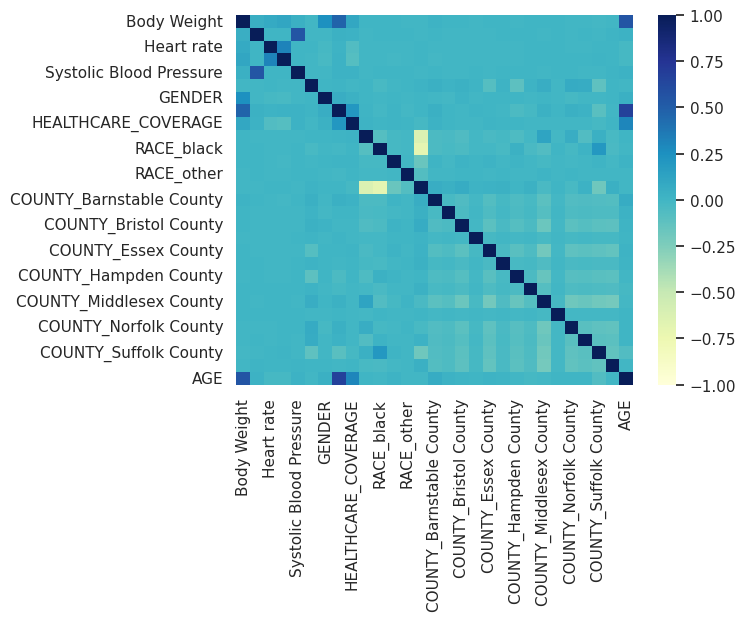

In [ ]:
# Correlation Heatmap
sb.heatmap(main_df.corr(), cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
cleaned_main_df = main_df.drop(columns=['Id', "DATE", 'PATIENT', 'ENCOUNTER'])

In [ ]:
# grouped_main_df = main_df.groupby('Id').median().reset_index()

In [ ]:
# grouped_main_df.dtypes

In [ ]:
print("The shape of the final dataset is: ",cleaned_main_df.shape)

The shape of the final dataset is:  (469898, 29)


In [ ]:
# patients_main_df = grouped_main_df.drop(columns=['Id'])
patients_main_df = cleaned_main_df

<Axes: >

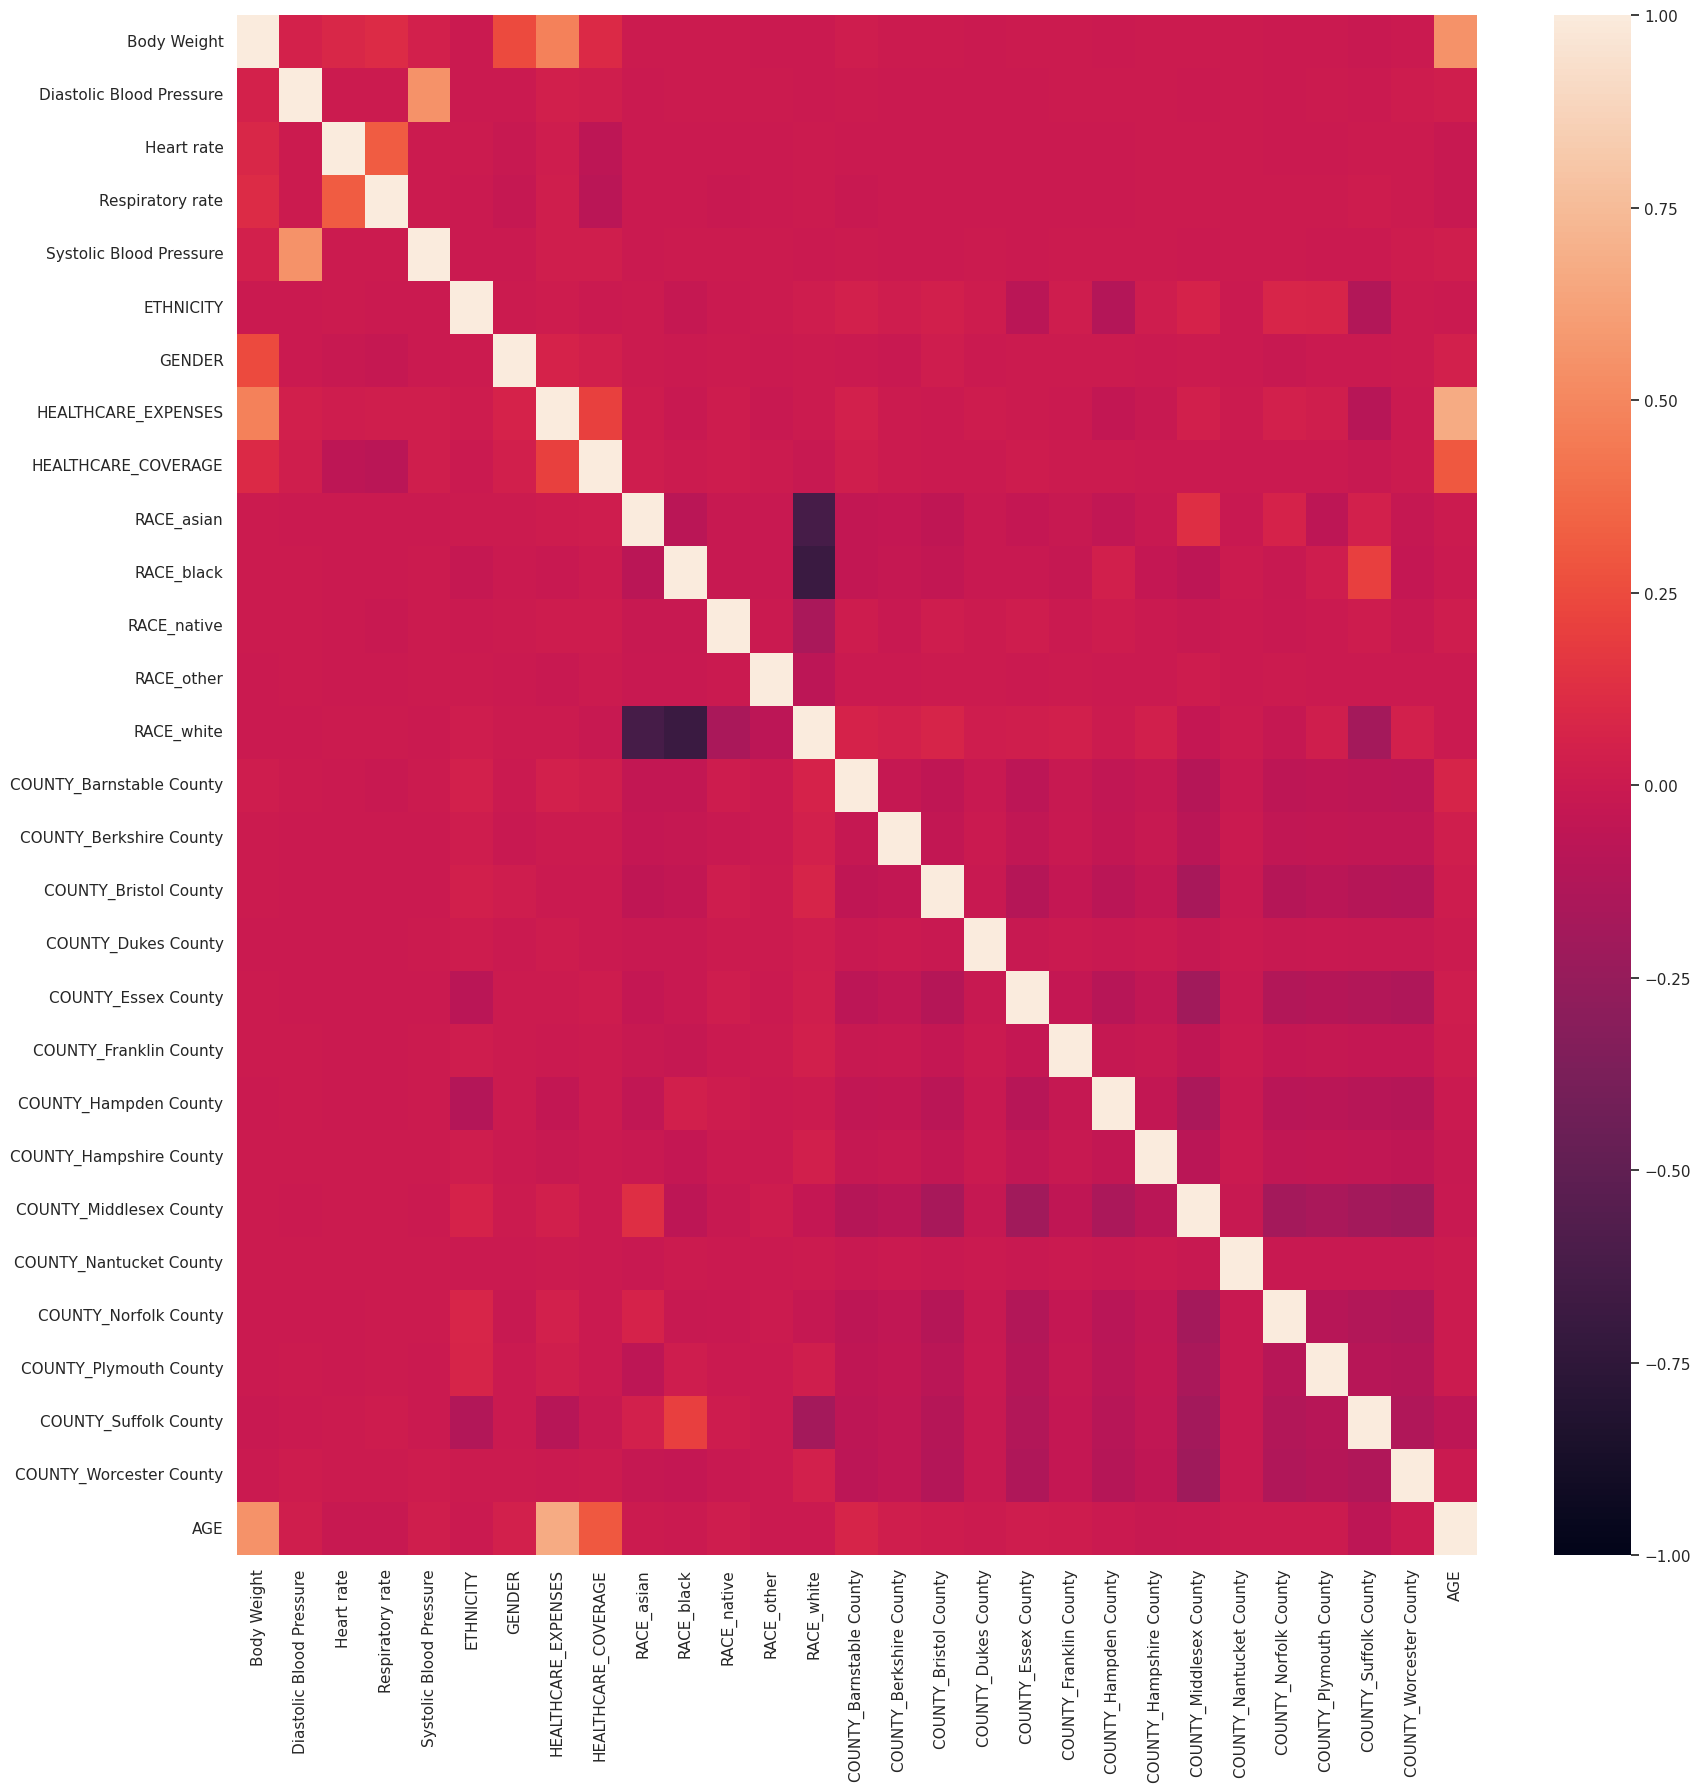

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sb.heatmap(patients_main_df.corr() , annot=False, vmin=-1, vmax=1)

In [ ]:
patients_main_df.to_csv('data3.csv')

#### Only COVID-19 patients

In [ ]:
covid_cleaned_main_df = pd.read_csv('cleaned_main_df')

In [ ]:
covid_cleaned_main_df.head()

,Unnamed: 0,PATIENT_x,Body Weight,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,ORGANIZATION,PROVIDER,PAYER,DESCRIPTION,PAYER_COVERAGE
0,0,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,79.0,76.0,35.0,120.0,19,39,2,2,59.16
1,1,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,79.0,189.0,12.0,122.0,19,39,2,2,59.16
2,2,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,74.0,184.0,20.0,126.0,19,39,2,2,59.16
3,3,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,76.0,113.0,30.0,125.0,19,39,2,2,59.16
4,4,641699c3-03c0-40fc-9f14-38247e0a8cfa,67.0,71.0,58.0,35.0,124.0,19,39,2,2,59.16


In [ ]:
covid_cleaned_main_df = covid_cleaned_main_df.drop(columns=['Unnamed: 0'])

In [ ]:
# Renaming column to Id
covid_cleaned_main_df = covid_cleaned_main_df.rename(columns = {"PATIENT_x":"Id"})

In [ ]:
# Grouping patients by Id
covid_grouped_main_df = covid_cleaned_main_df.groupby('Id').median().reset_index()

In [ ]:
covid_grouped_main_df.dtypes

Id                           object
Body Weight                 float64
Diastolic Blood Pressure    float64
Heart rate                  float64
Respiratory rate            float64
Systolic Blood Pressure     float64
ORGANIZATION                float64
PROVIDER                    float64
PAYER                       float64
DESCRIPTION                 float64
PAYER_COVERAGE              float64
dtype: object

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading encounters dataset
covid_encounters_df = pd.read_csv('drive/MyDrive/BMIN_522_Project/dataset/covid19/encounters.csv') #*

In [ ]:
covid_encounters_df = covid_encounters_df.dropna(subset=['REASONDESCRIPTION'])

In [ ]:
# Selecting only COVID-19 patients 
covid_encounters_df = covid_encounters_df.loc[((covid_encounters_df['REASONDESCRIPTION'] == 'COVID-19') | (covid_encounters_df['REASONDESCRIPTION'] == 'Suspected COVID-19'))]


#### COVID-19 patients - merge

In [ ]:
covid_main_df = covid_grouped_main_df.merge(patients_f_df, on='Id', how='inner')

In [ ]:
covid_main_df.dtypes

Id                           object
Body Weight                 float64
Diastolic Blood Pressure    float64
Heart rate                  float64
Respiratory rate            float64
Systolic Blood Pressure     float64
ORGANIZATION                float64
PROVIDER                    float64
PAYER                       float64
DESCRIPTION                 float64
PAYER_COVERAGE              float64
ETHNICITY                     int64
GENDER                        int64
HEALTHCARE_EXPENSES         float64
HEALTHCARE_COVERAGE         float64
RACE_asian                    uint8
RACE_black                    uint8
RACE_native                   uint8
RACE_other                    uint8
RACE_white                    uint8
COUNTY_Barnstable County      uint8
COUNTY_Berkshire County       uint8
COUNTY_Bristol County         uint8
COUNTY_Dukes County           uint8
COUNTY_Essex County           uint8
COUNTY_Franklin County        uint8
COUNTY_Hampden County         uint8
COUNTY_Hampshire County     

In [ ]:
covid_final_df = covid_main_df.drop(columns=['Id'])

In [ ]:
covid_final_df.dtypes

Body Weight                 float64
Diastolic Blood Pressure    float64
Heart rate                  float64
Respiratory rate            float64
Systolic Blood Pressure     float64
ORGANIZATION                float64
PROVIDER                    float64
PAYER                       float64
DESCRIPTION                 float64
PAYER_COVERAGE              float64
ETHNICITY                     int64
GENDER                        int64
HEALTHCARE_EXPENSES         float64
HEALTHCARE_COVERAGE         float64
RACE_asian                    uint8
RACE_black                    uint8
RACE_native                   uint8
RACE_other                    uint8
RACE_white                    uint8
COUNTY_Barnstable County      uint8
COUNTY_Berkshire County       uint8
COUNTY_Bristol County         uint8
COUNTY_Dukes County           uint8
COUNTY_Essex County           uint8
COUNTY_Franklin County        uint8
COUNTY_Hampden County         uint8
COUNTY_Hampshire County       uint8
COUNTY_Middlesex County     

In [ ]:
# Saving the final curated dataset
all_patients = pd.read_csv('data3.csv')

In [ ]:
all_patients.dtypes

Unnamed: 0                               int64
Body Weight                            float64
Body temperature                       float64
Diastolic Blood Pressure               float64
Heart rate                             float64
Oxygen saturation in Arterial blood    float64
Respiratory rate                       float64
Systolic Blood Pressure                float64
ETHNICITY                                int64
GENDER                                   int64
HEALTHCARE_EXPENSES                    float64
HEALTHCARE_COVERAGE                    float64
RACE_asian                               int64
RACE_black                               int64
RACE_native                              int64
RACE_other                               int64
RACE_white                               int64
COUNTY_Barnstable County                 int64
COUNTY_Berkshire County                  int64
COUNTY_Bristol County                    int64
COUNTY_Dukes County                      int64
COUNTY_Essex 

<Axes: >

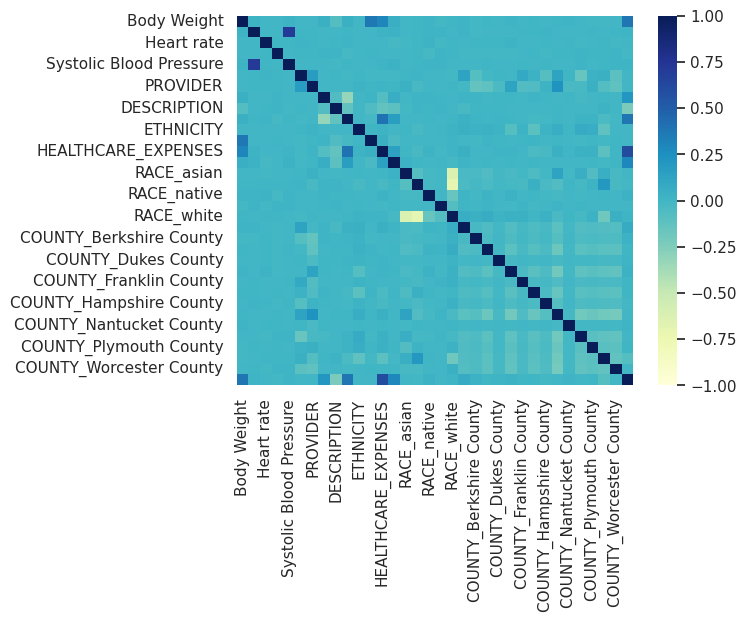

In [ ]:
sb.heatmap(covid_final_df.corr(), cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
covid_final_df.shape

(18177, 34)

In [ ]:
covid_final_df.to_csv('data3b.csv')

## Data Loading

In [ ]:
patients_main_df.dtypes

In [ ]:
# patients_main_df = pd.read_csv('data3.csv') # All patients --> Models take ~20+ minutes to train in total
patients_main_df = pd.read_csv('data3b.csv') # COVID-19 patients only

In [ ]:
patients_main_df = patients_main_df.drop(columns=['Unnamed: 0'])

In [ ]:
patients_main_df.shape

(18177, 34)

In [ ]:
# Creating the X (independent variables) and y (target variable) dataframe
df_X = patients_main_df.loc[:, ~patients_main_df.columns.isin(['HEALTHCARE_EXPENSES'])]
df_Y = patients_main_df[['HEALTHCARE_EXPENSES']]

In [ ]:
# # Creating the X (independent variables) and y (target variable) dataframe
# df_X = patients_f_df.loc[:, ~patients_f_df.columns.isin(['HEALTHCARE_EXPENSES'])]
# df_Y = patients_f_df[['HEALTHCARE_EXPENSES']]

In [ ]:
# df_X = df_X.drop(columns=['Id'])

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42) 
# X_trainval, X_test, y_trainval, y_test = train_test_split(df_X, df_Y, test_size=0.1, random_state=42) 
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42) 

In [ ]:
# y_train = np.asarray(y_train).reshape(-1)
# # y_val = np.asarray(y_val).reshape(-1)
# y_test = np.asarray(y_test).reshape(-1)

In [ ]:
# X_train = np.asarray(X_train)
# # X_val = np.asarray(X_val)
# X_test = np.asarray(X_test)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
# print("X_val.shape: ", X_val.shape)
# print("y_val.shape: ", y_val.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (14541, 33)
y_train.shape:  (14541, 1)
X_test.shape:  (3636, 33)
y_test.shape:  (3636, 1)


In [ ]:
# Standard sclaing
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
# X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

In [ ]:
# Experimenting with PCA
# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train_std)
# X_test_pca = pca.transform(X_test_std)

## Modeling

In [ ]:
# Average healthcare expenses
print('Average expenditure in training dataset: ', y_train.mean())
print('Average expenditure in test dataset: ', y_test.mean())

Average expenditure in training dataset:  HEALTHCARE_EXPENSES    965333.773352
dtype: float64
Average expenditure in test dataset:  HEALTHCARE_EXPENSES    953588.629147
dtype: float64


In general, the average healthcare expenditure of COVID-19 patients was greater than the absolute average of healthcare expenses of the populatiom

### Linear Regression

In [ ]:
# Training the Linear Regression Model
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train_std,y_train)
# lin_reg = lin_reg.fit(X_train_pca,y_train)

In [ ]:
# Prediction
lin_train_preds = lin_reg.predict(X_train_std)
lin_test_preds = lin_reg.predict(X_test_std)
# lin_train_preds = lin_reg.predict(X_train_pca)
# lin_test_preds = lin_reg.predict(X_test_pca)

In [ ]:
# Training Error
print("Training RMSE = ",mean_squared_error(y_train, lin_train_preds, squared=False))

Training RMSE =  400957.568806539


In [ ]:
# Testing Error
print("Testing RMSE = ",mean_squared_error(y_test, lin_test_preds, squared=False))

Testing RMSE =  406034.611740816


### Ridge Regression with Grid Search CV

In [ ]:
# cross validation to prevent overfitting
cross_val = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

In [ ]:
# defining the parameter choices for grid search CV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'solver':['svd','lsqr'],
    'fit_intercept':[True, False]   
}

In [ ]:
# Defining the ridge regression model
ridge_reg_gscv = Ridge()

In [ ]:
grid_search_cv = GridSearchCV(estimator=ridge_reg_gscv, param_grid = param_grid, cv = cross_val)

In [ ]:
# Training using grid search cv
grid_search_cv.fit(X_train_std, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'lsqr']})

In [ ]:
# Prediction
cv_train_preds = grid_search_cv.predict(X_train_std)
cv_test_preds = grid_search_cv.predict(X_test_std)

In [ ]:
# Training Error
print("Training RMSE = ",mean_squared_error(y_train, cv_train_preds, squared=False))

Training RMSE =  400957.63860827876


In [ ]:
# Testing Error
print("Testing RMSE = ",mean_squared_error(y_test, cv_test_preds, squared=False))

Testing RMSE =  406032.2102538684


In [ ]:
# Best model obtained after grid search
grid_search_cv.best_estimator_

Ridge(alpha=10, solver='svd')

In [ ]:
grid_search_cv.best_params_

{'alpha': 10, 'fit_intercept': True, 'solver': 'svd'}

### Random Forest Regressor

In [ ]:
# Defining random forest regression model
rf_reg= RandomForestRegressor(max_depth=3, n_estimators=1000, min_samples_leaf=5, max_samples=0.3, oob_score=True)

In [ ]:
# Fitting the model to scaled training data
rf_reg.fit(X_train_std, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=3, max_samples=0.3, min_samples_leaf=5,
                      n_estimators=1000, oob_score=True)

In [ ]:
# Prediction
rf_train_preds = rf_reg.predict(X_train_std)
rf_test_preds = rf_reg.predict(X_test_std)

In [ ]:
# Training Error
print("Training RMSE = ",mean_squared_error(y_train, rf_train_preds, squared=False))

Training RMSE =  349838.5782397292


In [ ]:
# Testing Error
print("Testing RMSE = ",mean_squared_error(y_test, rf_test_preds, squared=False))

Testing RMSE =  360472.1166415471


In [ ]:
# OOB score for random forest model
rf_reg.oob_score_

0.5728226717486895

### Gradient Boost Regressor

In [ ]:
# Defining the gradient boosting regression model
gbr = GradientBoostingRegressor(max_depth=4, min_samples_split=5, n_estimators = 400, learning_rate=0.01)

In [ ]:
# Fitting the model to scaled training data
gbr.fit(X_train_std, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=400)

In [ ]:
# Prediction
gbr_train_preds = gbr.predict(X_train_std)
gbr_test_preds = gbr.predict(X_test_std)

In [ ]:
# Training Error
print("Training RMSE = ",mean_squared_error(y_train, gbr_train_preds, squared=False))

Training RMSE =  224099.63882298992


In [ ]:
# Testing Error
print("Testing RMSE = ",mean_squared_error(y_test, gbr_test_preds, squared=False))

Testing RMSE =  234975.34662318032


Text(0.5, 1.0, 'Feature Importance')

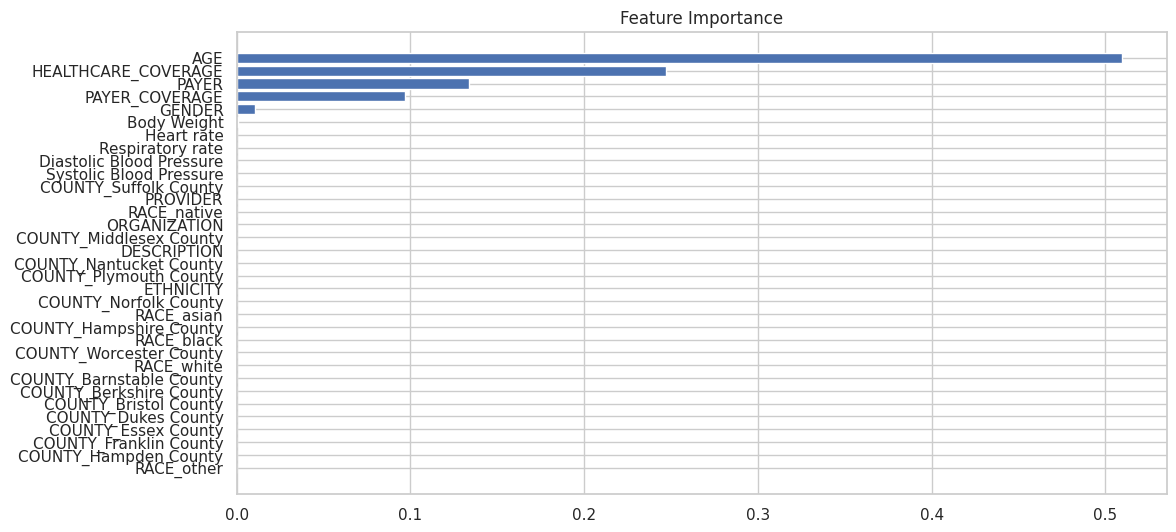

In [ ]:
# Feature importance
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'SHAP Importance')

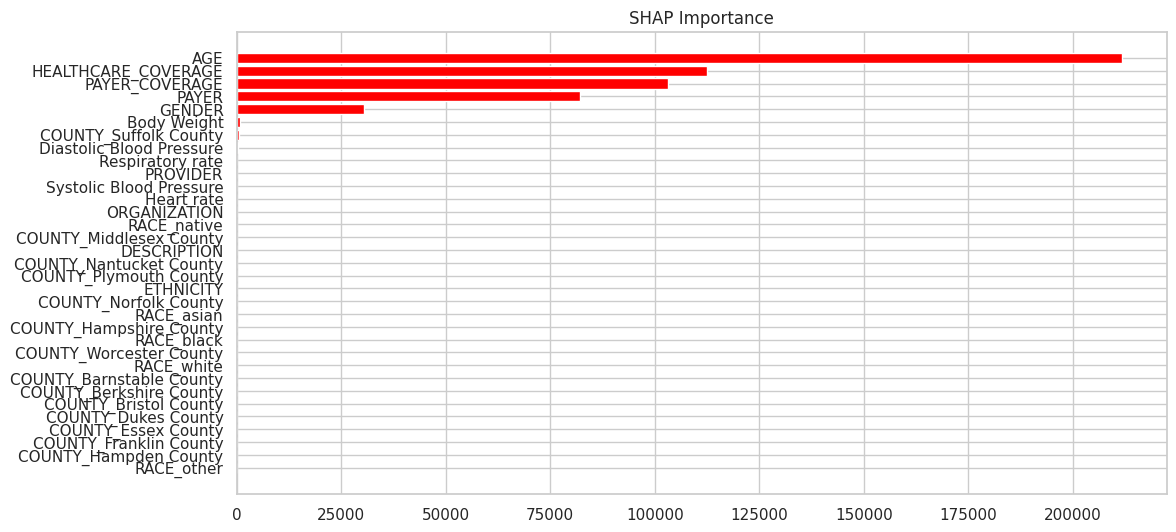

In [ ]:
# SHAP values
explainer = shap.Explainer(gbr)
shap_values = explainer(X_test_std)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center', color='red')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')